In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
# For the time series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
# tools
from sklearn.metrics import mean_squared_error
from itertools import chain

# Aim
The aim of my study is to predict the house prices after the crash in 2008 for the following 10 years. The data is quarterly data from the year 1975 to 2018. The best performing models will be used to predict the next 3 month period, but I will also try to predict long term trend2, 2 year period.
Trying to use "All-Transactions House Price Index for the United States" for my challenge.<br>
DataSource:https://fred.stlouisfed.org/series/USSTHPI <br>
<br>

# Loading the data

In [2]:
df= pd.read_csv('USSTHPI.csv')
# adjust the date column
df.index = pd.to_datetime(df.DATE)
print(df.shape)
df.head()

(184, 2)


,DATE,USSTHPI
DATE,,
1975-01-01,1/1/1975,59.83
1975-04-01,4/1/1975,61.13
1975-07-01,7/1/1975,61.25
1975-10-01,10/1/1975,62.35
1976-01-01,1/1/1976,62.85


In [3]:
df.dtypes

DATE        object
USSTHPI    float64
dtype: object

# Differentiating

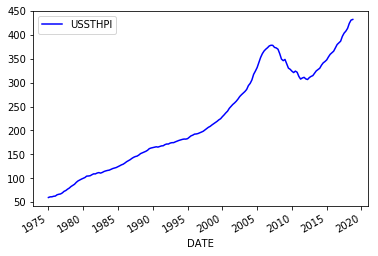

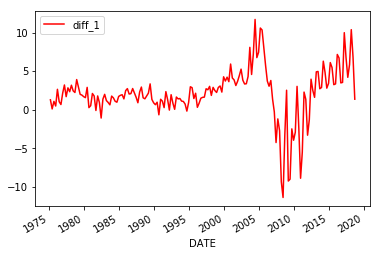

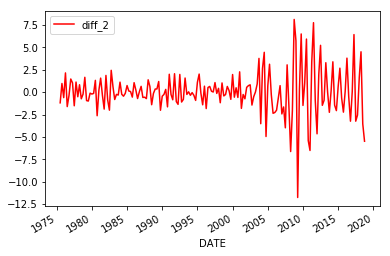

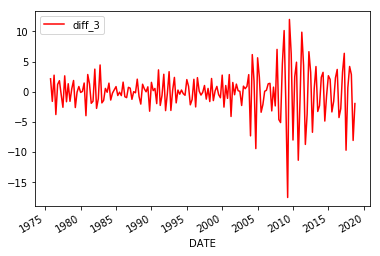

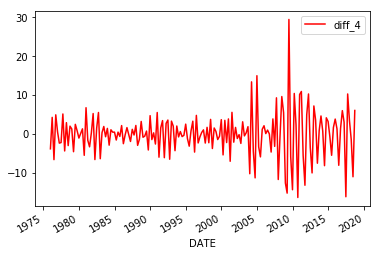

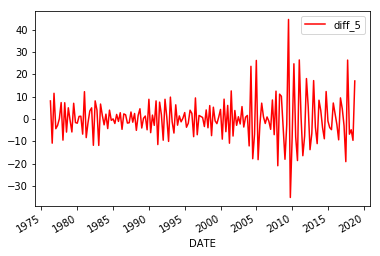

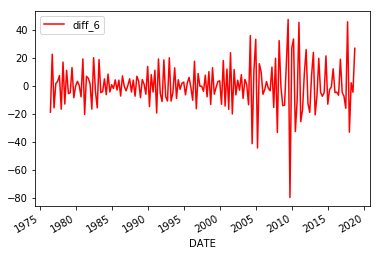

In [4]:
df['diff_1'] = df.USSTHPI - df.USSTHPI.shift()
df['diff_2'] = df.diff_1 - df.diff_1.shift()
df['diff_3'] = df.diff_2 - df.diff_2.shift()
df['diff_4'] = df.diff_3 - df.diff_3.shift()
df['diff_5'] = df.diff_4 - df.diff_4.shift()
df['diff_6'] = df.diff_5 - df.diff_5.shift()
#Plot the data

df.plot(y='USSTHPI',c='b')
plt.show()

df.plot(y='diff_1',c='r') #row=0, col=0
plt.show()
df.plot(y='diff_2',c='r') #row=1, col=0
plt.show()
df.plot(y='diff_3',c='r') #row=1, col=0
plt.show()
df.plot(y='diff_4',c='r') #row=1, col=0
plt.show()
df.plot(y='diff_5',c='r') #row=1, col=0
plt.show()
df.plot(y='diff_6',c='r') #row=1, col=0
plt.show()

For some reason the integrations beyond diff_3 do not realy help anymore.
# Partial autoregression estimate

Text(0.5, 1.0, 'USSTHPI PACF')

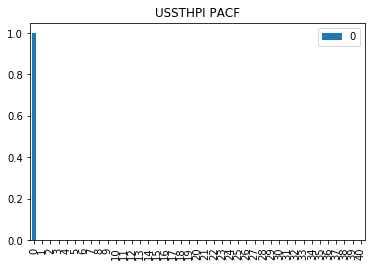

In [5]:
x_acf = pd.DataFrame(pacf(df.USSTHPI))
x_acf.plot(kind='bar')
plt.title("USSTHPI PACF")

One strong autocorrelation. So the diff data should not have any.

Text(0.5, 1.0, 'USSTHPI diff_1 PACF')

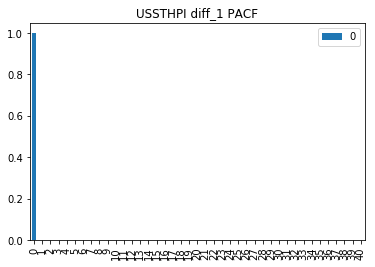

In [6]:
x_acf = pd.DataFrame(pacf(df.diff_1))
x_acf.plot(kind='bar')
plt.title("USSTHPI diff_1 PACF")

As expected this differentiation eiliminates the autocorrelation. Time to built a model.

# Quarterly prediction
## ARIMA models
There are many combinations of parameters for the ARIMA model that need to tested, in order to make this more automated, let's implement a grid search.
Idea from here(https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/). Training data will be the time period till the crash (till 2008) and the test data will be the data past 2008. 
### Data prep


In [7]:
df['Year']= pd.to_numeric(df.DATE.str.split("/",n=2, expand=True)[2])
df.head()

,DATE,USSTHPI,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,Year
DATE,,,,,,,,,
1975-01-01,1/1/1975,59.83,NaN,NaN,NaN,NaN,NaN,NaN,1975.0
1975-04-01,4/1/1975,61.13,1.30,NaN,NaN,NaN,NaN,NaN,1975.0
1975-07-01,7/1/1975,61.25,0.12,-1.18,NaN,NaN,NaN,NaN,1975.0
1975-10-01,10/1/1975,62.35,1.10,0.98,2.16,NaN,NaN,NaN,1975.0
1976-01-01,1/1/1976,62.85,0.50,-0.60,-1.58,-3.74,NaN,NaN,1976.0


In [8]:
train= df.USSTHPI[df.Year<2008]
print(len(train))
test= df.USSTHPI[df.Year>2008]
print(len(test))

print('Training set size:',round(len(train)/(len(train)+len(test))*100,2),"%")
print('Test set size:',round(len(test)/(len(train)+len(test))*100,2),"%")

132
40
Training set size: 76.74 %
Test set size: 23.26 %


### Grid search

In [9]:
# actual function to run ARIMA model predicted the next quarters value
def evaluate_arima_model(train,test, arima_order):
# prepare training dataset
    #train_size = int(len(X) * 0.66)
    #train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t]) # This model only predicts the next quarter
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    #print(error)
    return error

In [10]:
import warnings
warnings.filterwarnings("ignore")

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train,test, ar_values, d_values, ma_values):
    train = train.astype('float32')
    test = test.astype('float32')
    lowest_error, best_cfg = float("inf"), None
    for ar in ar_values:
        for d in d_values:
            for ma in ma_values:
                order = (ar,d,ma)
                #print(order)
                try:
                    mse = evaluate_arima_model(train,test, order)
                    #print(mse)
                    if mse < lowest_error:
                        lowest_error, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    #print('except')
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, lowest_error))

In [11]:
# Okay let's try some parameters
ar_values = [0, 1, 2, 3, 4, 6]
d_values = range(0, 5)
ma_values = range(0, 3)
evaluate_models(train, test, ar_values, d_values, ma_values)

ARIMA(0, 0, 0) MSE=23279.347
ARIMA(0, 0, 1) MSE=5943.076
ARIMA(0, 1, 0) MSE=39.997
ARIMA(0, 1, 1) MSE=31.438
ARIMA(0, 1, 2) MSE=27.531
ARIMA(0, 2, 0) MSE=30.698
ARIMA(0, 2, 1) MSE=25.433
ARIMA(0, 2, 2) MSE=28.758
ARIMA(1, 0, 0) MSE=41.542
ARIMA(1, 1, 0) MSE=27.047
ARIMA(1, 2, 0) MSE=28.193
ARIMA(1, 2, 1) MSE=26.770
ARIMA(2, 2, 0) MSE=28.829
ARIMA(3, 1, 0) MSE=26.984
ARIMA(3, 2, 0) MSE=30.865
ARIMA(3, 2, 1) MSE=35.955
ARIMA(4, 1, 0) MSE=28.529
ARIMA(4, 2, 0) MSE=34.793
ARIMA(6, 1, 0) MSE=32.692
Best ARIMA(0, 2, 1) MSE=25.433


Do the models with the lowest error also have good AIC scores?

In [12]:
# To run a single ARIMA and look at the stats
def runARIMA(data,p,d,q):
    model= ARIMA(data, order=(p,d,q)) 
    model_fit = model.fit()
    print(model_fit.summary())
    print('Residuals Description')
    print(model_fit.resid.describe())

### 0,2,1 MSE=25.433 ( AIC = 784)

In [13]:
runARIMA(df.USSTHPI.dropna(),0,2,1)

                             ARIMA Model Results                              
Dep. Variable:             D2.USSTHPI   No. Observations:                  174
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -389.253
Method:                       css-mle   S.D. of innovations              2.264
Date:                Fri, 08 Mar 2019   AIC                            784.506
Time:                        21:59:03   BIC                            793.983
Sample:                    07-01-1975   HQIC                           788.350
                         - 10-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0219      0.076      0.290      0.772      -0.126       0.170
ma.L1.D2.USSTHPI    -0.5624      0.060     -9.330      0.000      -0.681      -0.444
                            

### 1,2,1 MSE=26.7 ( AIC = 807)

In [14]:
runARIMA(df.USSTHPI.dropna(),1,2,0)

                             ARIMA Model Results                              
Dep. Variable:             D2.USSTHPI   No. Observations:                  174
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -400.722
Method:                       css-mle   S.D. of innovations              2.421
Date:                Fri, 08 Mar 2019   AIC                            807.444
Time:                        21:59:03   BIC                            816.921
Sample:                    07-01-1975   HQIC                           811.289
                         - 10-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0041      0.166      0.025      0.980      -0.321       0.329
ar.L1.D2.USSTHPI    -0.1063      0.076     -1.392      0.166      -0.256       0.043
                            

### 2,2,1 MSE=88, but best AIC =713

In [15]:
runARIMA(df.USSTHPI.dropna(),2,2,1)

                             ARIMA Model Results                              
Dep. Variable:             D2.USSTHPI   No. Observations:                  174
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -351.645
Method:                       css-mle   S.D. of innovations              1.820
Date:                Fri, 08 Mar 2019   AIC                            713.289
Time:                        21:59:03   BIC                            729.084
Sample:                    07-01-1975   HQIC                           719.697
                         - 10-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0242      0.071      0.343      0.732      -0.114       0.163
ar.L1.D2.USSTHPI    -0.1461      0.084     -1.745      0.083      -0.310       0.018
ar.L2.D2.USSTHPI    -0.6620 

Let's look at the accuracy of the top predictions (lowest MSE and lowest AIC)
## The quarterly predictions vs. reality

In [16]:
topMSE=( 0,2,1)
topAIC=( 2,2,1)

def runARIMA2(train, test, order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    return(predictions)

In [17]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)

In [18]:
# get the quarterly predictions for the two best models
TopMSEpred= flatten(runARIMA2(train, test.dropna(), topMSE))
TopMSEpred = [ x for x in TopMSEpred]

TopAICpred= flatten(runARIMA2(train, test.dropna(), topAIC))
TopAICpred = [ x for x in TopAICpred]

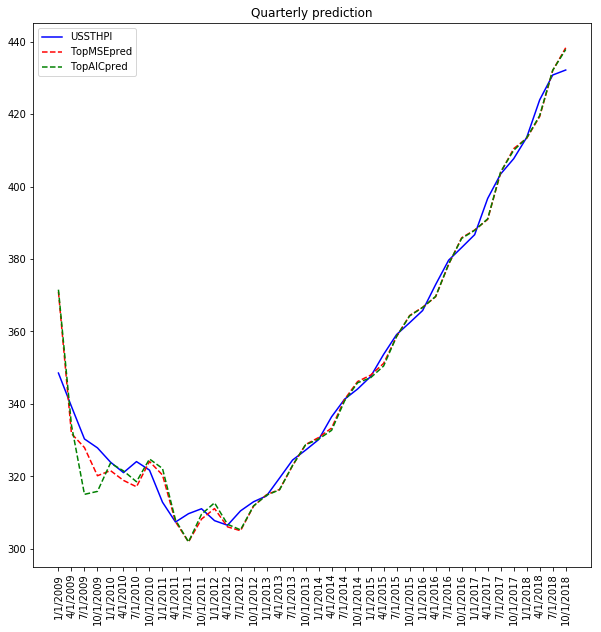

In [19]:
# Combine the data
df_test = df[df.Year>2008].dropna()
df_test['TopMSEpred']=TopMSEpred
df_test['TopAICpred']=TopAICpred
# Make the plot
plt.figure(figsize=(10,10))
plt.plot('DATE', 'USSTHPI', data=df_test,c='b')
plt.plot('DATE', 'TopMSEpred',data=df_test,c='r',linestyle='dashed')
plt.plot('DATE', 'TopAICpred',data=df_test, c='g',linestyle='dashed')
plt.legend()
plt.title('Quarterly prediction')
plt.xticks(rotation=90)
plt.show()

The prediction for the next quarter turns out to work well, no matter which model is used. BUt what if the time frame for prediction is more long term? Let's try to model the whole time period from 2017 -2018.

# 2-year predictions


## Trainings data

In [20]:
train2= df.USSTHPI[df.Year<2017].dropna()
print(len(train))
test2= df.USSTHPI[df.Year>=2017].dropna()
print(len(test))

print('Training set size:',round(len(train2)/(len(train2)+len(test2))*100,2),"%")
print('Test set size:',round(len(test2)/(len(train2)+len(test2))*100,2),"%")

132
40
Training set size: 95.45 %
Test set size: 4.55 %


## Grid search

In [21]:
# actual function to run ARIMA model, newly predicted data is added to the test set
def evaluate_arima_model2(train,test, arima_order):
# prepare training dataset
    #train_size = int(len(X) * 0.66)
    #train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(yhat) # Adding the predicted value to the train set
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    #print(error)
    return error
# evaluate combinations of p, d and q values for an ARIMA model

def evaluate_models2(train,test, ar_values, d_values, ma_values):
    train = train.astype('float32')
    test = test.astype('float32')
    lowest_error, best_cfg = float("inf"), None
    for ar in ar_values:
        for d in d_values:
            for ma in ma_values:
                order = (ar,d,ma)
                #print(order)
                try:
                    mse = evaluate_arima_model2(train,test, order)
                    #print(mse)
                    if mse < lowest_error:
                        lowest_error, best_cfg = mse, order
                    #print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    #print('except')
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, lowest_error))

In [22]:
# Okay let's try some parameters
ar_values = [0, 1, 2, 3, 4, 6, 7, 8]
d_values = range(0, 5)
ma_values = range(0, 5)
evaluate_models2(train2, test2, ar_values, d_values, ma_values)

Best ARIMA(0, 2, 3) MSE=21.772


Intrestingly the model that predicts long term results best, is different from the short term predictions. The data takes much more previous data into consideration, which obviously makes a lot of sense. What is the AIC score for this model?
## 6,2,2 MSE=24.11 AIC=706

In [23]:
runARIMA(df.USSTHPI.dropna(),6,2,2)

                             ARIMA Model Results                              
Dep. Variable:             D2.USSTHPI   No. Observations:                  174
Model:                 ARIMA(6, 2, 2)   Log Likelihood                -343.197
Method:                       css-mle   S.D. of innovations              1.729
Date:                Fri, 08 Mar 2019   AIC                            706.394
Time:                        22:10:07   BIC                            737.985
Sample:                    07-01-1975   HQIC                           719.209
                         - 10-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0210      0.099      0.213      0.831      -0.172       0.214
ar.L1.D2.USSTHPI     0.8902      0.148      6.020      0.000       0.600       1.180
ar.L2.D2.USSTHPI    -1.0697 

## 0,2,3 MSE=21.772 AIC=729

In [24]:
runARIMA(df.USSTHPI.dropna(),0,2,3)

                             ARIMA Model Results                              
Dep. Variable:             D2.USSTHPI   No. Observations:                  174
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -359.954
Method:                       css-mle   S.D. of innovations              1.907
Date:                Fri, 08 Mar 2019   AIC                            729.909
Time:                        22:10:07   BIC                            745.704
Sample:                    07-01-1975   HQIC                           736.316
                         - 10-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0221      0.092      0.241      0.810      -0.158       0.202
ma.L1.D2.USSTHPI    -0.5227      0.063     -8.241      0.000      -0.647      -0.398
ma.L2.D2.USSTHPI    -0.3872 

In [25]:
topMSElong=( 0,2,3)
topAIClong=( 6,2,2)

def runARIMA_longTerm(train, test, order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(yhat)
    return(predictions)

In [26]:
# get the 2 year predictions for the two best models
TopMSElongpred= flatten(runARIMA_longTerm(train2, test2.dropna(), topMSElong))
TopMSElongpred = [ x for x in TopMSElongpred]

TopAIClongpred= flatten(runARIMA_longTerm(train2, test2.dropna(), topAIClong))
TopAIClongpred = [ x for x in TopAIClongpred]

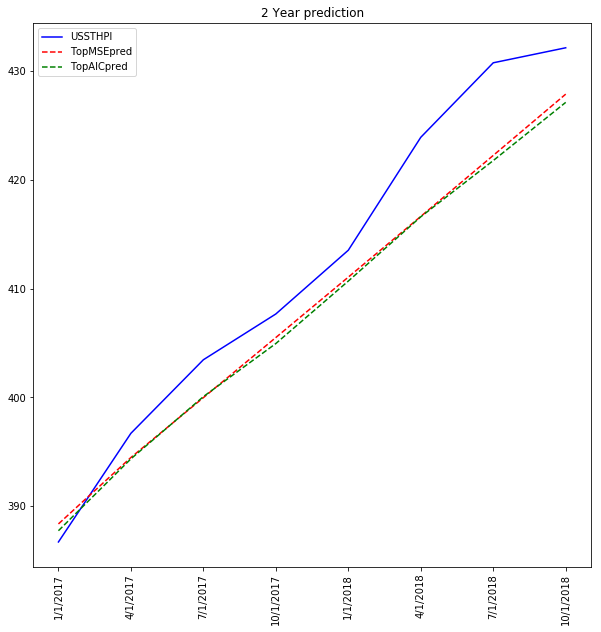

In [27]:
# Combine the data
df_test = df[df.Year>=2017].dropna()
df_test['TopMSEpred']=TopMSElongpred
df_test['TopAICpred']=TopAIClongpred
# Make the plot
plt.figure(figsize=(10,10))
plt.plot('DATE', 'USSTHPI', data=df_test,c='b')
plt.plot('DATE', 'TopMSEpred',data=df_test,c='r',linestyle='dashed')
plt.plot('DATE', 'TopAICpred',data=df_test, c='g',linestyle='dashed')
plt.title('2 Year prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Results 
Using a grid search and looking out for low AIC scores, resulted in two decent models (TopMSE and TopAIC) to predict the progress of house prices in the US for a period of a quarter year and 2 years. The difference between the two models is relatively small, the two models perform well.
The long term model fails to predict subtle changes in the price and without any further information the prediction would predict house prices to increase forever. 